In [1]:
import sys
# Assuming we are in the notebook directory add this so that we can import the library
sys.path.append('..')

import numpy as np
from elfi.core import *
from elfi.distributions import *
from elfi.examples.ma2 import *
from elfi.methods import *
import elfi.simple_gp
from functools import partial

import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline


In [2]:
def fun(x):
    return np.sin(x) + x/10.

simple_model = elfi.simple_gp.SimpleGP(1, bounds=[(0,10)])
x_init = np.array([[3, 4, 7]]).T
y_init = fun(x_init)
simple_model.update(x_init, y_init)

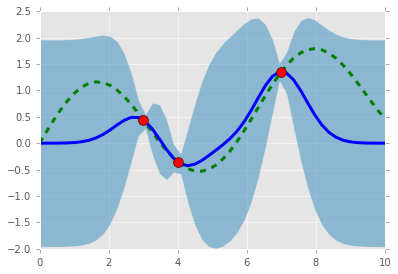

In [3]:
simple_model.plot(fun);

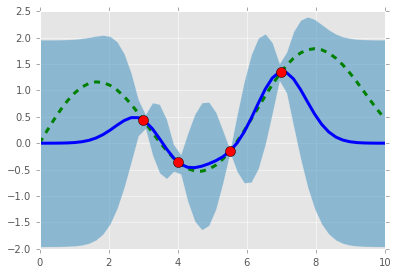

In [4]:
simple_model.update(np.array([[5.5]]), np.array([[fun(5.5)]]))
simple_model.plot(fun);

In [5]:
n = 100
t1 = 0.6
t2 = 0.2

# Set up observed data y
latents = np.random.randn(n+2)
y = MA2(n, 1, t1, t2, latents=latents)

# Plot
if False:
    plt.figure(figsize=(11, 6))
    plt.plot(np.arange(0,n),y[0,:])
    plt.scatter(np.arange(-2,n), latents);

In [9]:
# Set up the simulator
simulator = partial(MA2, n)

# Set up autocovariance summaries
ac1 = partial(autocov, 1)
ac2 = partial(autocov, 2)

# Specify the graphical model
t1 = Prior('t1', 'uniform', 0, 1)
#t2 = Prior('t2', 'uniform', 0, 1)
Y = Simulator('MA2', simulator, t1, t2, observed=y)
S1 = Summary('S1', ac1, Y)
S2 = Summary('S2', ac2, Y)
d = Discrepancy('d', distance, S1, S2)

# Specify the number of simulations
n_sim = 15
n_batch = 4

In [10]:
simple_model = elfi.simple_gp.SimpleGP(1, kernel=partial(elfi.simple_gp._cov_fun, gamma=100.))
d_init = d.generate(3).compute()
t1_init = t1.acquire(3).compute()
params_init = t1_init
simple_model.update(params_init, d_init)

GpyModel: No bounds supplied, defaulting to [0,1] bounds.


Sampling 15 samples in batches of 4
Using minimum value of discrepancy estimate mean (-51596.3528) as threshold


 /Users/vuolleko/anaconda/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1769: RuntimeWarning:divide by zero encountered in double_scalars
 ../elfi/simple_gp.py:53: RuntimeWarning:invalid value encountered in sqrt


ML parameters: [ 0.65011034]
MAP parameters: [ 0.85173722]


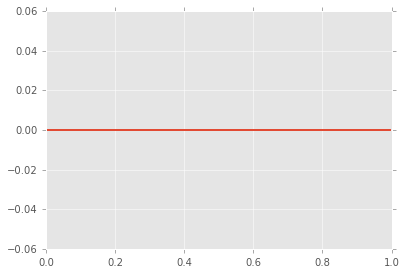

In [11]:
bolfi = BOLFI(10, d, [t1], batch_size=n_batch, n_surrogate_samples=n_sim, model=simple_model)
post = bolfi.infer()
post.plot()

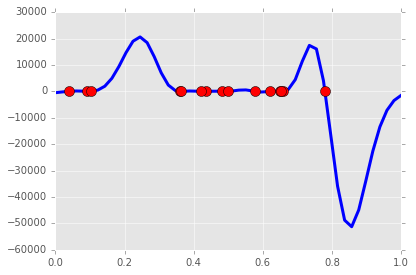

In [19]:
fig, ax = bolfi.model.plot()
# ax[0].set_ylim(-1000, 1000)